In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import requests

In [47]:
solar_data = pd.read_csv('/content/Nise_solar_data.csv')
solar_data.drop(columns=['Timestamp', 'Panel Temp (degC)', 'Array Voltage (V)', 'Array Current (A)'], inplace=True)
solar_data = solar_data.apply(pd.to_numeric, errors='coerce').dropna()

features = solar_data.iloc[:, :-1]
target = solar_data.iloc[:, -1]

scaler_features = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_features.fit_transform(features)

print("Features used for training:", features.columns.tolist())


scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 24
X, y = create_sequences(features_scaled, target_scaled, time_steps)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Features used for training: ['Air Temp (degC)', 'Wind Speed (cm/s)', 'Solar Radiation (W/m2)']


In [48]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0097 - val_loss: 0.0035
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0055 - val_l

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034
Test Loss: 0.0035259041469544172


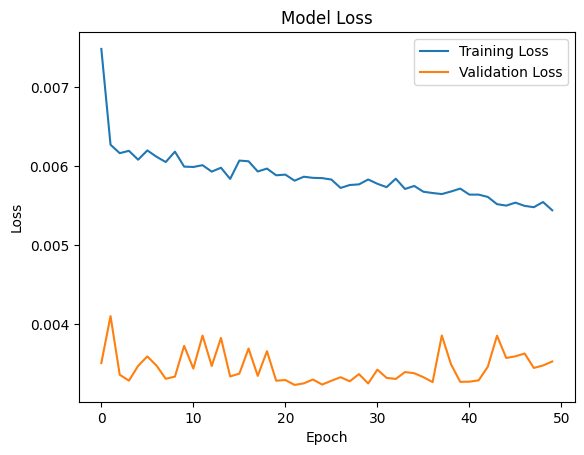

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


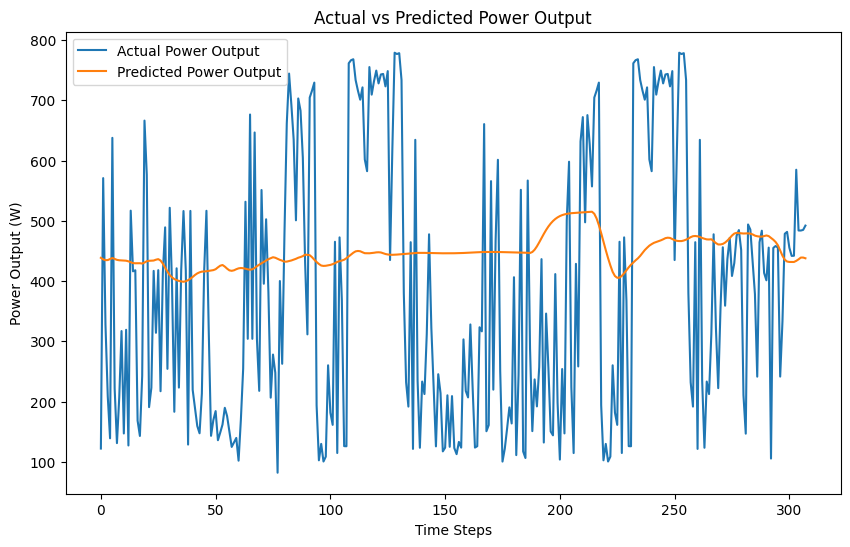

In [49]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred = model.predict(X_test)

y_test_actual = scaler_target.inverse_transform(y_test)
y_pred_actual = scaler_target.inverse_transform(y_pred)

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Power Output')
plt.plot(y_pred_actual, label='Predicted Power Output')
plt.title('Actual vs Predicted Power Output')
plt.xlabel('Time Steps')
plt.ylabel('Power Output (W)')
plt.legend()
plt.show()

In [51]:
# Define the coordinates for Cairo, Egypt
latitude = 30.0444
longitude = 31.2357

params = {
    'latitude': latitude,
    'longitude': longitude,
    'hourly': ['temperature_2m','wind_speed_10m','direct_radiation']  # Assuming direct_radiation aligns with Solar Radiation
}

url = "https://api.open-meteo.com/v1/forecast"

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    if 'hourly' in data:
        hourly_data = data['hourly']

        temperatures = hourly_data['temperature_2m']
        wind_speeds_kmh = hourly_data['wind_speed_10m']
        solar_radiations = hourly_data['direct_radiation']  # Assume this corresponds to 'Solar Radiation (W/m2)'

        # Convert wind speeds from km/h to cm/s (1 km/h = 27.7778 cm/s)
        wind_speeds_cms = [speed * 27.7778 for speed in wind_speeds_kmh]

        # Select the latest hour data for prediction
        latest_temperature = temperatures[-1]
        latest_wind_speed = wind_speeds_cms[-1]
        latest_solar_radiation = solar_radiations[-1]

        input_features = np.array([[latest_temperature, latest_wind_speed, latest_solar_radiation]])

        input_features_scaled = scaler_features.transform(input_features)

        time_steps = 24
        X_new = np.tile(input_features_scaled, (time_steps, 1)).reshape(1, time_steps, -1)

        predicted_power_output_scaled = model.predict(X_new)

        predicted_power_output = scaler_target.inverse_transform(predicted_power_output_scaled)

        print(f"Predicted Power Output: {predicted_power_output[0][0]} W")
    else:
        print("Hourly data not available in the response.")
else:
    print(f"Request failed with status code: {response.status_code}")
    print("Response message:", response.text)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted Power Output: 417.64947509765625 W
